In [11]:
# Convert to python script, remember to delete/comment the next line in the actual file
# ! jupyter nbconvert --to python generatePreprocessCombinations.ipynb --output generatePreprocessCombinations.py

### # Imports

In [12]:
# Image reading and file handling 
import pandas as pd
import SimpleITK as sitk 
import os 
import shutil
from matplotlib import pyplot as plt 
# Image agumentaitons 
import numpy as np
import cv2

# import scipy

# Dataset building
import torch
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchvision.transforms as transforms
import random



In [13]:
# ! pip freeze > requirements.txt
# ! pip uninstall -y -r requirements.txt

## Download necessary packages 
# ! pip install matplotlib opencv-python scipy simpleitk pandas openpyxl scikit-learn nbconvert
# ! pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118 

## For 3D image classification
# ! pip install foundation-cancer-image-biomarker -qq
# ! pip install foundation-cancer-image-biomarker
# ! pip install torchio

## Check python version and packages
# ! python --version
# ! pip freeze > research.txt

## Get the data from the .xsxl file

In [14]:
columns = ['TAPS_CaseIDs_PreNAT','RECIST_PostNAT', 'Slice_Thickness']
data = pd.read_excel('PDAC-Response_working.xlsx', header=None,names = columns)
data.drop(0, inplace=True) # Remove the header row
data=data.sort_values(by=['TAPS_CaseIDs_PreNAT'])

print(data[data['Slice_Thickness']==6])
# There is 1 case that is of 3 slice, remainder are of 6-29
data.drop(data[data['Slice_Thickness'] < 6].index, inplace = True)

# # Get the entire datasheet
cases = list(data['TAPS_CaseIDs_PreNAT'])
recistCriteria = list(data['RECIST_PostNAT'])

sliceThickness = list(data['Slice_Thickness'])
sliceThickness.sort()
print(len(sliceThickness))


from collections import Counter
recistCounter = Counter(recistCriteria)
print('Distribution of cases based on RECIST criteria',recistCounter)



   TAPS_CaseIDs_PreNAT RECIST_PostNAT Slice_Thickness
41             CASE520              1               6
53             CASE550              2               6
71             CASE586              2               6
82             CASE605              2               6
89
Distribution of cases based on RECIST criteria Counter({2: 40, 3: 28, 1: 21})


In [15]:
#Make the images aligned if not. Mainly just checks
#==========================================================================================
def makeAlign(image1,image2):
    image1.SetDirection(image2.GetDirection())
    image1.SetOrigin(image2.GetOrigin())
    image1.SetSpacing(image2.GetSpacing())
    return image1, image2

def isAligned(image1, image2):
    return image1.GetDirection() == image2.GetDirection() and image1.GetOrigin() == image2.GetOrigin() and image1.GetSpacing() == image2.GetSpacing()   

def resampleSizes(wholeHeader, segmentHeader):
    """ 
    Resamples the sitk image to have the same size based on the one with the largest size.
    """
    if wholeHeader.GetSize()[-1] >= segmentHeader.GetSize()[-1]:
        imageLarge = wholeHeader
        imageSmall = segmentHeader
        wholeThenSegmentOrder = True
    else:
        imageLarge = segmentHeader
        imageSmall = wholeHeader 
        wholeThenSegmentOrder = False

    resample = sitk.ResampleImageFilter()
    resample.SetReferenceImage(imageLarge)  
    resample.SetInterpolator(sitk.sitkLinear)  # Choose the interpolation method (sitkLinear, sitkNearestNeighbor, etc.)
    resample.SetDefaultPixelValue(0)  # Set default pixel value for areas outside the original image

    imageSmall = resample.Execute(imageSmall)

    print(f'imageLarge: {imageLarge.GetSize()}')
    print(f'imageSmall: {imageSmall.GetSize()}')
    

    if wholeThenSegmentOrder:
        return imageLarge, imageSmall # whole, then segment
    else:
        return imageSmall, imageLarge # segment, then whole
    
def twoImageAlignProceess(wholeHeader,segmentHeader,verbose):    

    error = False
    # Check if the images are aligned
    wholeHeader, segmentHeader = makeAlign(wholeHeader, segmentHeader)
    imagesAreAligned = isAligned(wholeHeader, segmentHeader)
    print(f'Are the two images aligned now?: {imagesAreAligned}' if verbose==2 else '',end='')

    if not imagesAreAligned:
        error = True
        return None, None, True
    
    # Set the spacing of the image to 1x1x1mm voxel spacing
    wholeHeader.SetSpacing([1,1,1])
    segmentHeader.SetSpacing([1,1,1])
    imagesSpacingAligned = wholeHeader.GetSpacing() == segmentHeader.GetSpacing() 
    print(f'Are the two images aligned in terms of spacing?: {imagesSpacingAligned}' if verbose==2 else '',end='')

    if not imagesSpacingAligned:
        error = True
        return None, None, True
    
    imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
    print(f'Are the two images aligned in terms of size?: {imagesSizeAligned}' if verbose==2 else '',end='')

    if not imagesSizeAligned:
        wholeHeader, segmentHeader = resampleSizes(wholeHeader, segmentHeader)
        print(f'whole size: {wholeHeader.GetSize()}')
        print(f'segment size: {segmentHeader.GetSize()}')
        imagesSizeAligned = wholeHeader.GetSize() == segmentHeader.GetSize() 
        print(f'Are the two images aligned in terms of size now?: {imagesSizeAligned}' if verbose==2 else '',end='')
        if not imagesSizeAligned:
            error = True
            return None, None, True

    return wholeHeader, segmentHeader, False


In [16]:
# Image changing and conversion
#==========================================================================================

def window_image_to_adbomen(image, window_center, window_width):
    img_max = window_center + int(window_width / 2)
    img_min = window_center - int(window_width / 2)
    return np.clip(image, img_min, img_max)

def centerXYOfImage(overlay_mask, segment_mask, segmentedSlices, padding=(5,5), scaledBoxes = None):
    """ 
    Centers the X and Y of the image to crop the image. segmentedSlices is given as an array of z-value slices because the same approach to x_indicies and y_indicies does not work on overlay_segment (works for x and y though)
    """
    _, x_indices, y_indices = np.where(segment_mask == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    center_x = (min_x + max_x) // 2
    center_y = (min_y + max_y) // 2

    if scaledBoxes == None: # Define width and height in regards of the single image
        width = abs(max_x - min_x) // 2
        height = abs(max_y - min_y) // 2
    else:
        width = scaledBoxes[0]//2
        height = scaledBoxes[1]//2

    # Get the dimensions of the cropped image
    start_x = max(0, center_x - width - padding[0]//2)
    end_x = min(segment_mask.shape[1], center_x + width + padding[0]//2)
    start_y = max(0, center_y - height - padding[1]//2)
    end_y = min(segment_mask.shape[2], center_y + height + padding[1]//2)

    return overlay_mask[np.array(segmentedSlices), start_x:end_x, start_y:end_y]

def resizeImageToDesiredResolution(images, resolution = (232,232)):
    """ Resize the image to the given resoloution"""
    resizedImages = []

    print('\nImages Shape:', images.shape)
    print(f"Input array dtype: {images.dtype}")
    for idx in range(images.shape[0]):
        try:
            image = images[idx,:,:]
            image = image.reshape((image.shape[0],image.shape[1])).astype('float32') #Need to convert to float to resize image
            image = cv2.resize(image, resolution, interpolation=cv2.INTER_CUBIC)
            resizedImages.append(image) #Conver the image back to int32 after resizing
             
        except cv2.error as e:
            print(f"Error during resizing slice {idx}: {e}")

    resizedImages = np.array(resizedImages)
    print(f"Output array size after CV2: {resizedImages.shape}")
    return resizedImages


In [49]:
# Displaying segments
#==========================================================================================

def displayCroppedSegmentations(croppedSegment):
    print(f'CroppedSegment shape: {croppedSegment.shape}')
    # Display the segmented image slices 

    columnLen = 10
    rowLen = max(2,croppedSegment.shape[0] // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(10, 10))
    
    rowIdx = 0
    for idx in range(croppedSegment.shape[0]):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1        
        axis[rowIdx][idx%columnLen].imshow(croppedSegment[idx,:,:] , cmap="gray")
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    
    plt.show()


def displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment):
    # Display the segmented image slices 
    columnLen = 10
    rowLen = max(2,len(segmentedSlices) // columnLen + 1) 
    figure,axis = plt.subplots( rowLen, columnLen, figsize=(20, 20))
    rowIdx = 0
    for idx in range(len(segmentedSlices)):        
        if idx%columnLen == 0 and idx>0:
            rowIdx += 1
        axis[rowIdx][idx%columnLen].imshow(augmented_whole[segmentedSlices[idx],:,:], cmap="gray")
        axis[rowIdx][idx%columnLen].imshow(augmented_segment[segmentedSlices[idx],:,:], cmap="Blues", alpha=0.25)
        axis[rowIdx][idx%columnLen].axis('off')

    # Turn off the axis of the rest of the subplots
    for i in range(idx+1, rowLen*columnLen):
        if i%columnLen == 0:
            rowIdx += 1
        axis[rowIdx][i%columnLen].axis('off')
    plt.show()


In [18]:
# Getting optimal slice(s) to use
#==========================================================================================


    
def getLargestSlice(mask):
 
    segmentedSlices = [] 
    for index in range(mask.shape[0]):
        if len(np.unique(mask[index,:,:])) > 1:
            segmentedSlices.append(index)

    mask_areas = []
    for slice_ in segmentedSlices:
        mask_areas.append(np.sum(mask[slice_,:,:]))


    indices = [i for i in range(len(segmentedSlices))]

    values = dict(zip(mask_areas, indices))
    values = dict(sorted(values.items()))
    
    return list(values.values())[-1], values

    

# def getLargestSlice(croppedSegment):
#     """
#     Finds the index with the largest slice in the croppedSegment and returns the index as well as the sorted number of slices each index has
#     """
#     max = 0
#     maxIndex = 0
    
#     indices = []
#     sliceTotals = []
#     for idx in range(croppedSegment.shape[0]):
#         unique, counts = np.unique(croppedSegment[idx,:,:], return_counts=True)
#         values = dict(zip(unique, counts))
#         sliceTotal = 0
#         for value,count in values.items():
#             sliceTotal += count if value > 0 else 0 
        
#         indices.append(idx)
#         sliceTotals.append(sliceTotal)
        
#         if sliceTotal > max: 
#             max = sliceTotal
#             maxIndex = idx 

#     values = dict(zip(sliceTotals,indices))
#     values = dict(sorted(values.items())) # Sort the values by number of slices

#     return maxIndex, values

def updateSlices(croppedSegment, mask, desiredNumberOfSlices=1):
    """
    Updates the number of slices to the number of slices given. 
    If the numberOfSlices > the number of slices in the croppedSegment, it will duplicate the slices of the largest slices 
    If the numberOfSlices < the number of slices in the croppedSegment, it will remove the slices with the least amount of information 
    If the numberOfSlices == the number of slices in the croppedSegment, it will do nothing     
    """
    print('desiredNumberOfSlices',desiredNumberOfSlices)
    if croppedSegment.shape[0] == desiredNumberOfSlices:
        return croppedSegment
    elif croppedSegment.shape[0] < desiredNumberOfSlices: # Duplicate slices from the largest slice

        # Specifications of croppedSegment
        original = np.copy(croppedSegment)
        largestSliceIndex, _ = getLargestSlice(mask)
        maxUpperBound = croppedSegment.shape[0] -1
        minLowerBound = 0
        
        # Specification of the values to duplicate
        numToDuplication = desiredNumberOfSlices - croppedSegment.shape[0] 
        ends = numToDuplication//2
        lowerRemainder = abs(largestSliceIndex - ends) if (largestSliceIndex - ends) < minLowerBound else 0   
        upperRemainder = abs(maxUpperBound - (largestSliceIndex + ends)) if largestSliceIndex + ends > maxUpperBound else 0 

        #Printing of the of the specifications
        print(f'LargestSegmentIdx = {largestSliceIndex}\nNumber of slices to duplicate: {numToDuplication}\n Ends: {ends}, \nlowerRemainder: {lowerRemainder},\n upperRemainder: {upperRemainder}')
        
        #Making of the range to center the slices to duplicate
        duplicationRange = list(range( largestSliceIndex - ends - upperRemainder + lowerRemainder , largestSliceIndex + ends + lowerRemainder - upperRemainder))

        print('preAdd',duplicationRange)
        #Edge case where we only need 1 extra slice
        if len(duplicationRange) == 0:
            duplicationRange = [largestSliceIndex]

        # Fixes the slices if we are off by 1
        if len(duplicationRange)+croppedSegment.shape[0] == desiredNumberOfSlices: 
            pass 
        else:
            # Add to the right side if the left will be out of bounds
            if duplicationRange[-1] -1 < minLowerBound:
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
            # Add to the left side if the right will be out of bounds
            elif duplicationRange[-1] +1 > maxUpperBound:
                duplicationRange = [duplicationRange[0] - 1] + duplicationRange
            else: #Default, add to the right side
                duplicationRange = duplicationRange + [duplicationRange[-1] + 1]
                
        print(f'CroppedSlices={list(range(0,croppedSegment.shape[0]))}\nSlices: {duplicationRange}')
        print(len(duplicationRange)+croppedSegment.shape[0])
        assert(len(duplicationRange)+croppedSegment.shape[0]== desiredNumberOfSlices) #Ensure that the desired number of slices is met

        #Insert the values
        croppedSegment = np.insert(croppedSegment, duplicationRange, original[duplicationRange,:,:], axis=0)
            
        print('greater than')
        return croppedSegment
    else:
        # Specifications of croppedSegment
        _, sliceValues = getLargestSlice(mask)
        numberOfSlicesToRemove =  croppedSegment.shape[0] - desiredNumberOfSlices 
        print(croppedSegment.shape)
        # Remove the slices with the least amount of information
        print(list(sliceValues.values()))
        print(list(sliceValues.values())[:numberOfSlicesToRemove])
        
        croppedSegment = np.delete(croppedSegment,list(sliceValues.values())[:numberOfSlicesToRemove], axis=0)
        print(croppedSegment.shape, f'Removed this many slices: {numberOfSlicesToRemove}')
        print('Less than')
        return croppedSegment


In [19]:
# Getting and finding the optimal dimensions for the bounding box
#==========================================================================================
def getSegmentBoxDimensions(preSegmentHeader):
    segment = sitk.GetArrayFromImage(preSegmentHeader)

    _, x_indices, y_indices = np.where(segment == 1)
    # Get the bounding box for x and y dimensions
    min_x, max_x = x_indices.min(), x_indices.max()
    min_y, max_y = y_indices.min(), y_indices.max()

    width = abs(max_x - min_x)
    height = abs(max_y - min_y)
    
    return width, height

def findLargestBoxSize(cases): 
    allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                    'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                    'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                    'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']


    onlySeeTheseCases = allFolders
    baseFilepath = 'Pre-treatment-only-pres/'

    largestWidth, largestHeight = 0,0
    # Find the largest box that fits all slices
    for folder in os.listdir(baseFilepath):
        # Skip cases that are not in the excel sheet
        if folder not in cases:
            continue
        # Exclude to cases that we haven't seen yet
        if folder not in onlySeeTheseCases:
            continue 
        count = 0
        for file in os.listdir(os.path.join(baseFilepath,folder)):
            if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
                preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
            else: 
                continue

            print(folder)
            width, height = getSegmentBoxDimensions(preSegmentHeader)
            print(f'Width= {width}, Height= {height} (Largest? {width > largestWidth} and {height > largestHeight})')
            print('=============================')

            # Get the largest width and height
            if width > largestWidth:
                largestWidth = width
            if height > largestHeight:  
                largestHeight = height


    dimensions = (largestWidth,largestHeight)
    return dimensions


#print('Largest dimension', findLargestBoxSize(cases))

## Perform preprocessing on multiple images


In [39]:
def preprocess(wholeHeader, segmentHeader, verbose=0, useBackground = False, scaledBoxes = None, desiredSliceNumber=12):
    """
    Preprocesses the wholeHeader and segmentHeader sitk images to be ready for augmentation 
    Verbose = 0: No output
    Verbose = 1: Only the CT scans slices and the array of slices it uses
    Verbose = 2: Everything
    Verbose = 3: Show the segment mask on top of the whole CT scan

    Returns: a np array windowed whole image, a np array cropped segment image to 64x64x[] resolution, and boolean error flag.
    """
    error = False # Error flag to check if there was an error in the preprocessing

    # Align the two images 
    wholeHeader, segmentHeader, error = twoImageAlignProceess(wholeHeader, segmentHeader, verbose) 
    if error:
        return None, None, error
    
    # Convert the images into numpy arrays for further processing, take the transpose as the format is z,y,x
    whole = sitk.GetArrayFromImage(wholeHeader)
    segment = sitk.GetArrayFromImage(segmentHeader)

    print(f'Spacing of whole:{whole.shape}' if verbose==2 else '',end='')
    print(f'Spacing of segment:{segment.shape}' if verbose==2 else '',end='')
    
    # Windowing parameters for the abdomen
    window_center = 40
    window_width = 350
    
    # Window and resample the whole image
    augmented_whole = window_image_to_adbomen(whole, window_center, window_width)


    # Get the slice indices where the segment is present in 
    augmented_segment = segment
    segmentedSlices = [] 
    for index in range(augmented_segment.shape[0]):
        if len(np.unique(augmented_segment[index,:,:])) > 1:
            segmentedSlices.append(index)

    print(f'Segment slice indices:{segmentedSlices}' if verbose==2 else '',end='')

    # Min-Max Normalize the values of the mask so the lower bound of the window is 0.0 and the upper bound is 1.0
    augmented_whole = (augmented_whole - np.min(augmented_whole)) / (np.max(augmented_whole) - np.min(augmented_whole))
    overlay_segment = augmented_whole * augmented_segment

    

    # Get the necessary padding for adding to the cropped image to make it a square
    paddingDim = [10,10]
    if scaledBoxes != None:
        # Rectangle, needs to reshape. Add padding to the smaller of the two dimensions
        print('Scaledboxes', scaledBoxes)
        
        difference = abs(scaledBoxes[1] - scaledBoxes[0])
        if scaledBoxes[0] >= scaledBoxes[1]:
            paddingWidth = difference
            paddingHeight = 0 
        else:
            paddingWidth = 0
            paddingHeight = difference
        paddingDim[0] += paddingHeight
        paddingDim[1] += paddingWidth


    print('paddingDim', paddingDim)
    # Crop the image to the center of the segmented region
    if useBackground:
        croppedSegment = centerXYOfImage(augmented_whole,augmented_segment,segmentedSlices, padding=paddingDim, scaledBoxes = scaledBoxes) 
    else:
        croppedSegment = centerXYOfImage(overlay_segment,augmented_segment,segmentedSlices, padding=paddingDim, scaledBoxes = scaledBoxes)      

    # Resize image to 224x224, or 299x299
    #croppedSegment = resizeImageToDesiredResolution(croppedSegment)


    if desiredSliceNumber==1:
        largestSlice, _ = getLargestSlice(augmented_segment)
        croppedSegment = croppedSegment[largestSlice,:,:]
    else:
        croppedSegment = updateSlices(croppedSegment,augmented_segment,desiredSliceNumber)

    #Display the results of preprocessing
    if verbose==1 or verbose==2:
        displayCroppedSegmentations(croppedSegment)
    elif verbose==3:
        displayOverlayedSegmentations(segmentedSlices, augmented_whole, augmented_segment)
    
    return whole, croppedSegment, error

In [21]:
#ADD argparser
import argparse
import sys
print('Current System:',sys.argv[0])

# python testSamples22-7.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine="" -hasBackground=False -usesGlobalSize=True
#Current
# python testSamples31-7-224x224.py -batchSize=8 -epochs=100 -lr=0.001 -evalDetailLine="view with 224x224 majourity voting" -hasBackground=t -usesLargestBox=f -segmentsMultiple=12 -dropoutRate=0.2 

# python generatePreprocessCombinations.py -hasBackground=f -usesLargestBox=f -segmentsMultiple=12 &&
# python generatePreprocessCombinations.py -hasBackground=t -usesLargestBox=t -segmentsMultiple=12 &&
# python generatePreprocessCombinations.py -hasBackground=f -usesLargestBox=t -segmentsMultiple=12 &&
# python generatePreprocessCombinations.py -hasBackground=t -usesLargestBox=f -segmentsMultiple=12 


#Check if we are using a notebook or not
if 'ipykernel_launcher' in sys.argv[0]:
    hasBackground = False
    usesLargestBox = True
    segmentsMultiple = 12


else:
    parser = argparse.ArgumentParser(description="Model information")
    parser.add_argument('-hasBackground', type=str, help='Whether to use the background (t to, f to not)', default='f')
    parser.add_argument('-usesLargestBox', type=str, help='Where to use the size of the largest box (t) or independent tumor boxes (f)', default='t')
    parser.add_argument('-segmentsMultiple', type=int, help='Segments a # of slices, 12 by default', default=12)
    
    args = parser.parse_args()
    hasBackground = True if args.hasBackground=='t' else False
    usesLargestBox = True if args.usesLargestBox=='t' else False
    segmentsMultiple = args.segmentsMultiple



print(f'Has Background: {hasBackground}, Uses Largest Box: {usesLargestBox}, Segments Multiple: {segmentsMultiple}')


Current System: d:\SimpsonLab\researchpip\lib\site-packages\ipykernel_launcher.py
Has Background: False, Uses Largest Box: True, Segments Multiple: 12


Using box dimension of: (82, 109)
CASE244 All files read:
Scaledboxes (82, 109)
paddingDim [37, 10]
desiredNumberOfSlices 6
(17, 118, 118)
[0, 16, 14, 1, 15, 2, 13, 11, 12, 3, 10, 8, 4, 9, 7, 6, 5]
[0, 16, 14, 1, 15, 2, 13, 11, 12, 3, 10]
(6, 118, 118) Removed this many slices: 11
Less than
Final Shape (6, 118, 118)


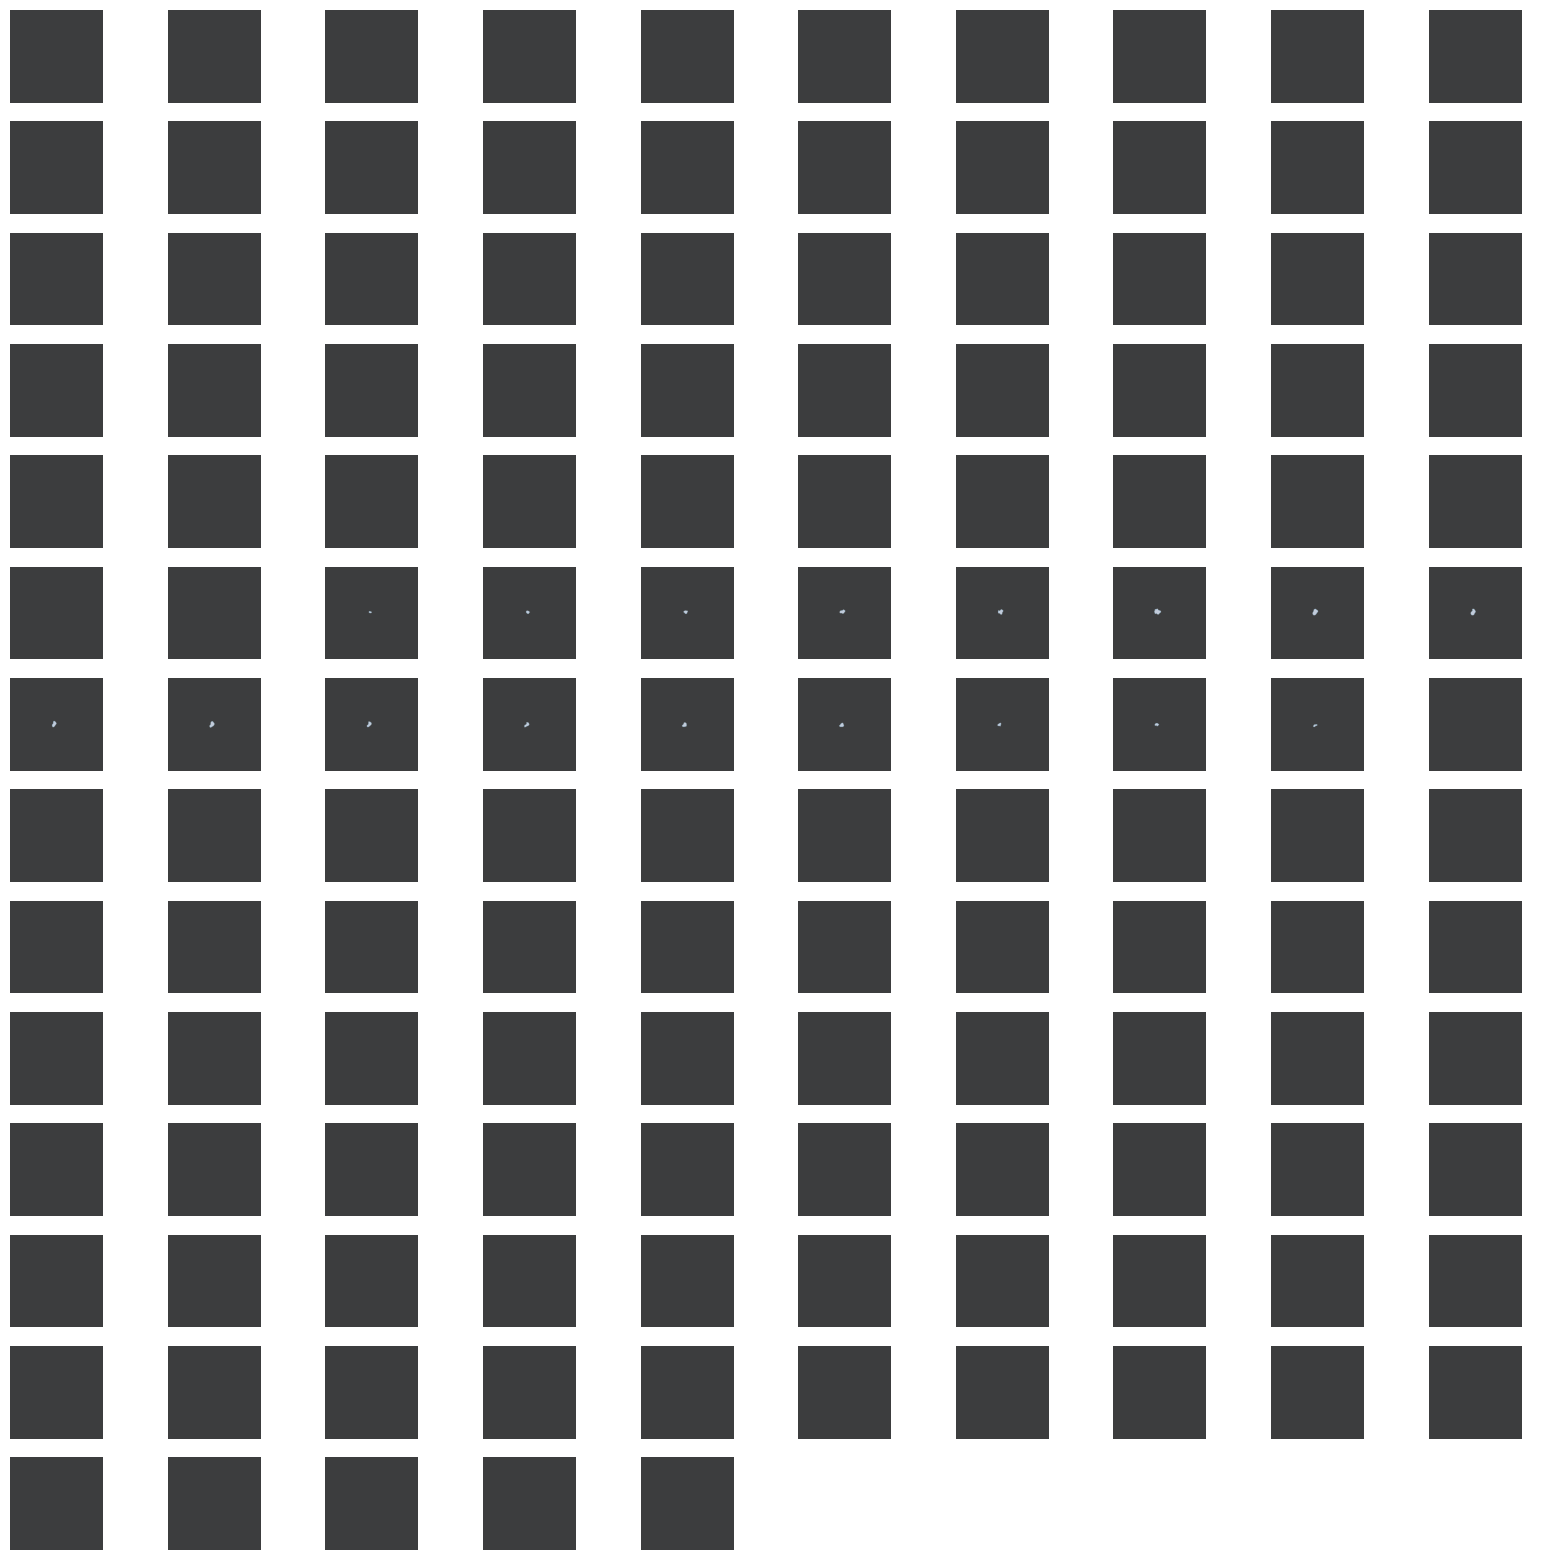

(1, 6, 118, 118)


In [50]:
def generatePreprocessCombinations(hasBackground, usesLargestBox, segmentsMultiple):
    allFolders = ['CASE244','CASE246','CASE247','CASE251','CASE254','CASE256','CASE263','CASE264','CASE265','CASE270','CASE272','CASE274',
                    'CASE467','CASE468','CASE470','CASE471','CASE472','CASE476','CASE479','CASE480','CASE482','CASE484','CASE485','CASE488','CASE494','CASE496','CASE499',
                    'CASE500','CASE505','CASE515','CASE520','CASE523','CASE525','CASE531','CASE533','CASE534','CASE535','CASE537','CASE539','CASE541','CASE543','CASE546','CASE547','CASE548','CASE549','CASE550','CASE551','CASE554','CASE555','CASE557','CASE559','CASE560','CASE562','CASE563','CASE564','CASE565','CASE568','CASE569','CASE572','CASE574','CASE575','CASE577','CASE578','CASE580','CASE581','CASE585','CASE586','CASE587','CASE588','CASE589','CASE593','CASE594','CASE596','CASE598',
                    'CASE600','CASE601','CASE602','CASE603','CASE604','CASE605','CASE608','CASE610','CASE611','CASE615','CASE616','CASE621','CASE622','CASE623','CASE624','CASE629','CASE630','CASE632','CASE635']


    # onlySeeTheseCases = allFolders#['CASE537','CASE585','CASE587']
    onlySeeTheseCases = ['CASE244']
    baseFilepath = 'Pre-treatment-only-pres/'
    desiredSliceNumber=segmentsMultiple
    croppedSegmentsList = []
    groups = []

    # Decide to use what size of box, either the largest box size for all images or one that just fits the tumor and resizes
    if usesLargestBox: # This is the largest of the whole dataset, including all patients
        dimensions = (82, 109)
        #dimensions = findLargestBoxSize(cases) #Find the largest dimension
    else:
        dimensions = None
    print('Using box dimension of:',dimensions)


    # Get all cropped segments
    for folder in sorted(os.listdir(baseFilepath)):
        # Skip cases that are not in the excel sheet
        if folder not in cases:
            continue
        # Exclude to cases that we haven't seen yet
        if folder not in onlySeeTheseCases:
            continue 
        count = 0
        preSegmentHeader = None
        wholeHeader = None
        for file in os.listdir(os.path.join(baseFilepath,folder)):
                
            if 'TUM' in file or 'SMV' in file: # pre-treatment segmentation 
                # segment, segmentHeader = nrrd.read(os.path.join(baseFilepath,folder,file))
                preSegmentHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
            elif file.endswith('CT.nrrd'): # whole ct scan
                wholeHeader = sitk.ReadImage(os.path.join(baseFilepath,folder,file))
        
        print('==============================================================')
        print(folder, 'All files read:')
        
        whole, croppedSegment,error = preprocess(wholeHeader, preSegmentHeader, verbose=0, useBackground=hasBackground, scaledBoxes=dimensions, desiredSliceNumber=segmentsMultiple) 
        if error:
            print('Error in preprocessing')
            # continue
        
        print('Final Shape', croppedSegment.shape)
        # groups += [folder]*desiredSliceNumber # Add the segment slices to the group
            
        croppedSegmentsList.append(croppedSegment)


        # ====================================
        whole = sitk.GetArrayFromImage(wholeHeader)
        segment = whole = sitk.GetArrayFromImage(preSegmentHeader)
        displayOverlayedSegmentations([i for i in range(whole.shape[0])], whole, segment)
        # augmented_whole = window_image_to_adbomen(whole, window_center, window_width)
        # displayCroppedSegmentations(whole)
        # displayCroppedSegmentations(croppedSegment)
        
    print(np.array(croppedSegmentsList).shape)
    #Save the results of the different combinations of backgrounds and sizes
    # name = f'preprocessCombinations/hasBackground={hasBackground}-usesLargestBox={usesLargestBox}-segmentsMultiple={segmentsMultiple}-size=(119,119)'

    # np.save(f'{name}.npy',np.array(croppedSegmentsList))

    # def loadFromNumpySave(name):
    #     data = np.load(f'{name}.npy')
    #     return data

    # readingTemp = loadFromNumpySave(name)
    # print('readingTemp Shape:', readingTemp.shape)     


# generatePreprocessCombinations(hasBackground, usesLargestBox, segmentsMultiple)
generatePreprocessCombinations(True, True, 6)
# generatePreprocessCombinations(False, False, 1)
# generatePreprocessCombinations(True, False, 1)
# generatePreprocessCombinations(False, True, 1)


In [14]:

CUDA_VISIBILE_DEVICES=0 python testSamples4-8-inceptionv3-finetune.py -batchSize=16 -epochs=100 -lr=0.001 -evalDetailLine='Small2D undersampled with 224x224 singleLargest' -hasBackground=t -usesLargestBox=t -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f -modelChosen='Small2D' -votingSystem='singleLargest' ;
CUDA_VISIBILE_DEVICES=0 python testSamples4-8-inceptionv3-finetune.py -batchSize=16 -epochs=100 -lr=0.001 -evalDetailLine='Small2D undersampled with 224x224 average voting' -hasBackground=t -usesLargestBox=t -segmentsMultiple=1 -dropoutRate=0.2 -grouped2D=f -modelChosen='Small2D' -votingSystem='average'


SyntaxError: invalid syntax (3430182940.py, line 1)

In [15]:
# name = f'preprocessCombinations/hasBackground={hasBackground}-usesLargestBox={usesLargestBox}-segmentsMultiple={segmentsMultiple}'
name = f'preprocessCombinations/hasBackground=True-usesLargestBox=True-segmentsMultiple=6-size=(119,119)'

# np.save(f'{name}.npy',np.array(croppedSegmentsList))
    
def loadFromNumpySave(name):
    data = np.load(f'{name}.npy')
    return data

readingTemp = loadFromNumpySave(name)
print('readingTemp Shape:', readingTemp.shape)   

readingTemp Shape: (89, 6, 232, 232)
